In [31]:
import math
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib as mpl
from collections import Counter
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors, DataStructs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import interpolate
import yaml
import random

classic_blue_hex = '#0f4c81'
coral_essence_hex = '#f26b5b'
lime_punch_hex = '#c0d725'
pink_tint_hex = '#dbcbbc'
pirate_black_hex = '#373838'
monument_hex = '#84898c'
jasmine_green_hex = '#7EC845'
cornhusk_hex = '#F3D5AD'
peach_quartz_hex = '#f5b895'
stucco_hex = "#A58D7F"
baby_blue_hex = "#B5C7D3"
provence_hex = '#658DC6'

la_gold = '#FDB927'
la_purple = '#552583'

df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')
df = df[['ligand_name', 'electrophile_id', 'nucleophile_id', 'yield']]
df['electrophile_id'] = df['electrophile_id'].apply(lambda x: x.lstrip('e')).astype('int')  # for sorting purposes, so 10 is not immediately after 1
df['nucleophile_id'] = df['nucleophile_id'].apply(lambda x: x.lstrip('n'))
ligands = list(df['ligand_name'].unique())

# plot all results. 4x6 for ligands, and each ligand is represented by a 8x8 block, overall 32x48
df = df.sort_values(by=['ligand_name', 'electrophile_id', 'nucleophile_id'])
ligand_names = list(df['ligand_name'].unique())
nuc_names = list(df['nucleophile_id'].unique())
elec_names = list(df['electrophile_id'].unique())

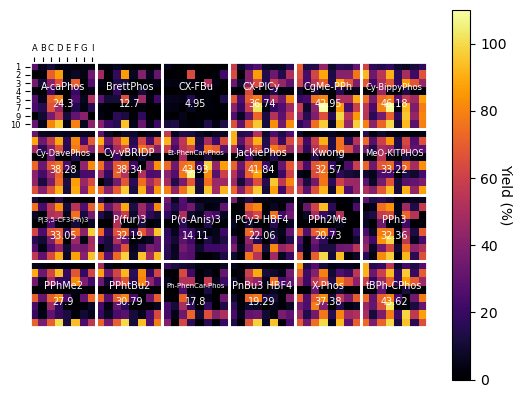

In [33]:
# Continue with above grid
l = []
averages = []
binary = 0
cutoff = 80

for ligand in ligand_names:
    tempdf = df.loc[df['ligand_name'] == ligand]
    tempdf = tempdf.drop(['ligand_name'], axis=1)
    a = np.array(tempdf.groupby(['electrophile_id'], sort=True)['yield'].apply(list).to_list())
    averages.append(np.average(a))
    # each row is an electrophile, each column is a nucleophile
    l.append(a)

a1 = np.hstack(l[0:6])
a2 = np.hstack(l[6:12])
a3 = np.hstack(l[12:18])
a4 = np.hstack(l[18:24])
a = np.vstack([a1, a2, a3, a4])

if binary:
    a = a > cutoff

fig, ax = plt.subplots()
text_kwargs = dict(ha='center', va='center', fontsize=7, color='white')
text_kwargs_fs6 = dict(ha='center', va='center', fontsize=6, color='white')
text_kwargs_fs5 = dict(ha='center', va='center', fontsize=5, color='white')

if binary:
    im = ax.imshow(a, cmap='inferno', vmin=0, vmax=2)
else:
    im = ax.imshow(a, cmap='inferno', vmin=0, vmax=110)

ii = 0
for i in range(4):
    for j in range(6):
        ax.add_patch(Rectangle((8*j-0.5, 8*i-0.5), 8, 8, fill=False, edgecolor='white', lw=2))
        if len(ligand_names[ii]) < 11:
            plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs)
        elif len(ligand_names[ii]) < 13:
            plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs_fs6)
        else:
            plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs_fs5)
        plt.text(8 * j + 3.5, 8 * i + 4.5, str(round(averages[ii], 2)), **text_kwargs)
        ii += 1

ax.set_yticks(np.arange(8))
ax.set_yticklabels(['1', '2', '3', '4', '5', '7', '9', '10'], fontsize=6)
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(np.arange(8))
ax_t.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I'], fontsize=6)
ax.set_xticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax_t.spines['top'].set_visible(False)

if not binary:
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Yield (%)', rotation=270)
plt.rcParams['savefig.dpi'] = 300
plt.show()

In [ ]:
#Test for five representative algorithms

In [17]:
%%time
%%capture
import pandas as pd
from algos_regret import EpsilonGreedy, UCB1, UCB1Tuned,ThompsonSamplingGaussianFixedVarSquared, BayesUCBGaussian
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/aryl-scope-ligand.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['ligand_name', 'electrophile_id', 'nucleophile_id', 'yield']]

ligands = ground_truth['ligand_name'].unique()
elecs = ground_truth['electrophile_id'].unique()
nucs = ground_truth['nucleophile_id'].unique()

scope_dict = {'ligand_name': ligands,
              'electrophile_id': elecs,
              'nucleophile_id': nucs}
arms_dict = {'ligand_name': ligands}
n_arms = len(ligands)
algos = [EpsilonGreedy(n_arms, 0.1),
         UCB1(n_arms),
         UCB1Tuned(n_arms),
         ThompsonSamplingGaussianFixedVarSquared(n_arms),
         BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),]

wkdir = '../dataset_logs/arylation-simulation/'
num_sims = 500
num_round = 150
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 8min 13s, sys: 21.1 s, total: 8min 34s
Wall time: 8min 30s


In [22]:
dirs ##check for correct content in dirs

['../dataset_logs/arylation-simulation/eps_greedy_0.1-500s-150r-1e/',
 '../dataset_logs/arylation-simulation/ucb1-500s-150r-1e/',
 '../dataset_logs/arylation-simulation/ucb1tuned-500s-150r-1e/',
 '../dataset_logs/arylation-simulation/ts_gaussian_squared-500s-150r-1e/',
 '../dataset_logs/arylation-simulation/bayes_ucb_gaussian_c=2_assumed_sd=0.25-500s-150r-1e/']

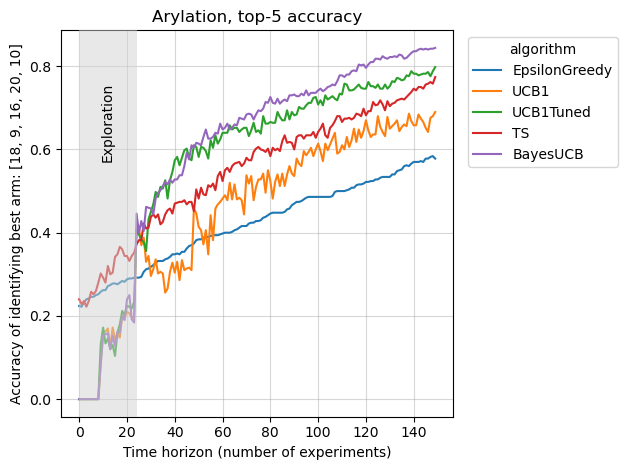

In [24]:
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['EpsilonGreedy','UCB1', 'UCB1Tuned', 'TS', 'BayesUCB']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-5 ligands that we want.
top5 = ['Cy-BippyPhos', 'Et-PhenCar-Phos', 'tBPh-CPhos', 'CgMe-PPh', 'JackiePhos']
ligands = [(l,) for l in top5]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in ligands]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=24,
                       title=f'Arylation, top-5 accuracy',
                       legend_title='algorithm',
                       long_legend=True)

In [ ]:
##Additional test for different BayesUCB algorithms and TS algorithms

In [21]:
%%time
%%capture
import pandas as pd
from algos_regret import BayesUCBBeta, BayesUCBGaussian, BayesUCBBetaPPF, ThompsonSamplingBeta, ThompsonSamplingGaussianFixedVarSquared
from chem_arms import simulate_propose_and_update
from utils import make_dir

ground_truth = pd.read_csv('../dataset/aryl-scope-ligand.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['ligand_name', 'electrophile_id', 'nucleophile_id', 'yield']]

ligands = ground_truth['ligand_name'].unique()
elecs = ground_truth['electrophile_id'].unique()
nucs = ground_truth['nucleophile_id'].unique()

scope_dict = {'ligand_name': ligands,
              'electrophile_id': elecs,
              'nucleophile_id': nucs}
arms_dict = {'ligand_name': ligands}
n_arms = len(ligands)
algos = [BayesUCBBeta(n_arms),
         BayesUCBGaussian(n_arms),
         BayesUCBBetaPPF(n_arms),
         ThompsonSamplingBeta(n_arms),
         ThompsonSamplingGaussianFixedVarSquared(n_arms),
        ]

wkdir = '../dataset_logs/arylation-simulation/'
num_sims = 200
num_round = 150
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 3min 49s, sys: 6.16 s, total: 3min 55s
Wall time: 3min 53s


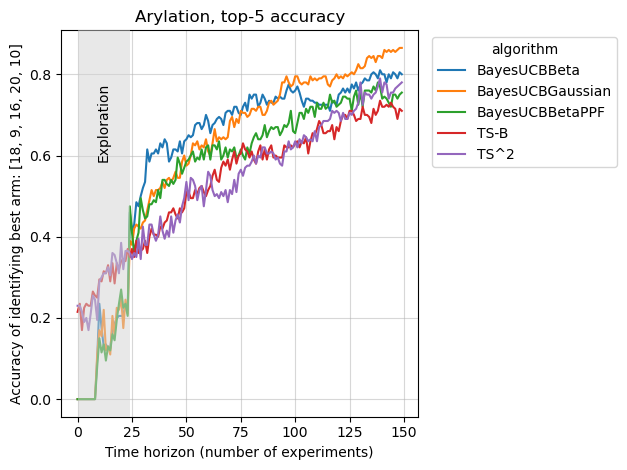

In [23]:
#test for different BayesUCB algorithms and TS algorithms
#Results shows BayesUCBGaussian gives the best performance in BayesUCB
# and ThompsonSamplingGaussianFixedVarSquared gives the best performance in TS algorithms
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['BayesUCBBeta','BayesUCBGaussian', 'BayesUCBBetaPPF', 'TS-B', 'TS^2']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-5 ligands that we want.
top5 = ['Cy-BippyPhos', 'Et-PhenCar-Phos', 'tBPh-CPhos', 'CgMe-PPh', 'JackiePhos']
ligands = [(l,) for l in top5]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in ligands]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=24,
                       title=f'Arylation, top-5 accuracy',
                       legend_title='algorithm',
                       long_legend=True)